In [50]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'
from collections import OrderedDict
import numpy as np
import networkx as nx
import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, GES, ICALiNGAM, GOLEM
import matplotlib.pyplot as plt

In [51]:
# Let's generate the data according to Fig 2. A.
x = np.random.randn(1000)
y = np.random.randn(1000)

z = x + y + .1 * np.random.randn(1000)
w = .7 * z + .1 * np.random.randn(1000)

# To matrix
pc_dataset = np.vstack([x, y, z, w]).T

# Sanity check
print(pc_dataset.shape)
print(pc_dataset)

# (1000, 4)

(1000, 4)
[[ 1.87   0.257  2.198  1.64 ]
 [-0.51  -0.642 -1.259 -0.929]
 [ 0.421  0.859  1.436  1.072]
 ...
 [-0.507 -1.226 -1.568 -1.079]
 [-0.72   1.064  0.294  0.12 ]
 [ 0.453  0.938  1.317  1.006]]


In [52]:
# Build the model
pc = PC()
pc.learn(pc_dataset)

# Print out the learned matrix
print(pc.causal_matrix)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]


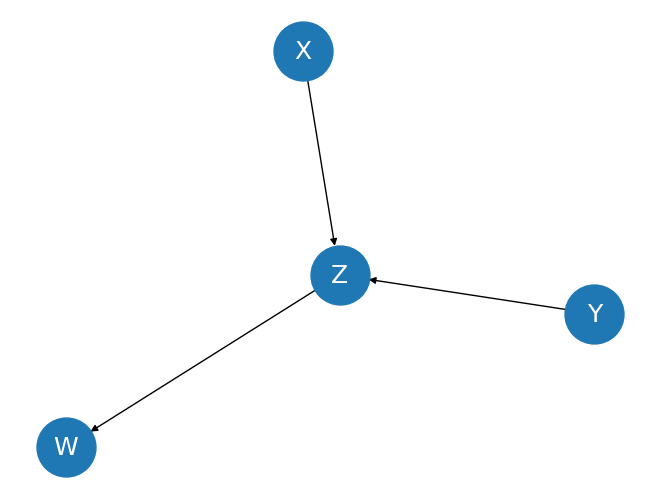

In [53]:
# Get learned graph
learned_graph = nx.DiGraph(pc.causal_matrix)

# Relabel the nodes
MAPPING = {k: v for k, v in zip(range(4), ['X', 'Y', 'Z', 'W'])}
learned_graph = nx.relabel_nodes(learned_graph, MAPPING, copy=True)

# Plot the graph
nx.draw(
    learned_graph, 
    with_labels=True,
    node_size=1800,
    font_size=18,
    font_color='white'
)

In [55]:
## Finding possible graphs

from itertools import product


undirected_edges = {frozenset(i) for i in learned_graph.edges() if learned_graph.has_edge(*i[::-1])}

possible_edges = list(product([0, 1], repeat = len(undirected_edges)))
print("All posiible graphs: " + str(len(possible_edges)))
# All possible graphs: 128

dags = []

for i in possible_edges:
    
    network = nx.DiGraph(pc.causal_matrix)
    
    for j, k in enumerate(i):
        
        l = [*list(undirected_edges)[j]][0]
        m = [*list(undirected_edges)[j]][1]
        
        network.remove_edge(l, m)
        network.remove_edge(m , l)
        
        if k == 0:
            network.add_edge(l, m)
        else:
            network.add_edge(m , l)
    
    if nx.is_directed_acyclic_graph(network):
        
        dags.append(network)

print("All DAGs: " + str(len(dags)))

All posiible graphs: 1
All DAGs: 1


In [62]:
from sklearn.datasets import load_wine
import pandas as pd

wine=load_wine()
data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

print(data.columns.to_list())
print(len(data.columns.to_list()))

# Build the model
pc = PC()
pc.learn(data)

# Print out the learned matrix
print(pc.causal_matrix)

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'target']
14
[[0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


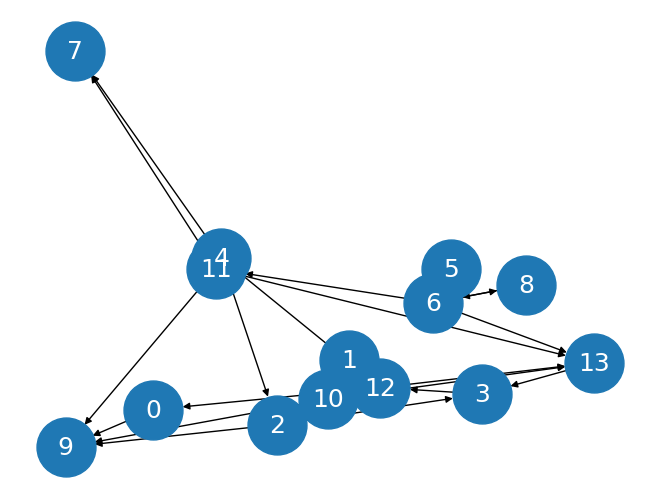

In [57]:
# Get learned graph
learned_graph = nx.DiGraph(pc.causal_matrix)

# Relabel the nodes
#MAPPING = {k: v for k, v in zip(range(4), ['X', 'Y', 'Z', 'W'])}
#learned_graph = nx.relabel_nodes(learned_graph, copy=True)

# Plot the graph
nx.draw(
    learned_graph, 
    with_labels=True,
    node_size=1800,
    font_size=18,
    font_color='white',
    #labels=data.columns.to_list(), 
    )

In [60]:
## Finding possible graphs

from itertools import product

undirected_edges = {frozenset(i) for i in learned_graph.edges() if learned_graph.has_edge(*i[::-1])}

possible_edges = list(product([0, 1], repeat = len(undirected_edges)))
print("All possible graphs: " + str(len(possible_edges)))

dags = []

for i in possible_edges:
    
    network = nx.DiGraph(pc.causal_matrix)
    
    for j, k in enumerate(i):
        
        l = [*list(undirected_edges)[j]][0]
        m = [*list(undirected_edges)[j]][1]
        network.remove_edge(l, m)
        network.remove_edge(m , l)
        
        if k == 0:
            network.add_edge(l, m)
        else:
            network.add_edge(m , l)
    
    if nx.is_directed_acyclic_graph(network):
        dags.append(network)

print("All DAGs: " + str(len(dags)))

# bic_calculator = BicScore(pd.DataFrame(data))
# bics = [bic_calculator.score(i) for i in dags]

# nx.draw(dags[bics.index(min(bics))], pos,
#         edge_color = edge_colors,
#         width=1,
#         linewidths = 1,
#         node_size = 600,
#         font_size = 6,
#         node_color = "pink",
#         alpha=0.9,
#         labels=dict(zip(range(len(labels)), labels)))

All possible graphs: 8
All DAGs: 0
